In [11]:
%matplotlib inline
from IPython.display import clear_output
import os
from copy import deepcopy

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import split_noniid, CustomSubset

from bayesian_torch.models.bayesian import resnet_variational as resnet
# from bayesian_torch.models.deterministic import resnet # deterministic model


torch.manual_seed(42)
np.random.seed(42)

Simulate non-iid data:

In [12]:
N_CLIENTS = 10
DIRICHLET_ALPHA = 0.2
Frac_Data = 0.5


data_train = datasets.CIFAR10(root="./cifar-10", train=True, download=True)
data_test = datasets.CIFAR10(root="./cifar-10", train=False, download=True)
# data_train = datasets.MNIST(root="./MNIST", train=True, download=True)
# data_test = datasets.MNIST(root="./MNIST", train=False, download=True)

mapp = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 
                 'dog', 'frog', 'horse', 'ship', 'truck'])
# mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])


train_idcs, test_idcs = np.random.permutation(int(len(data_train)*Frac_Data)), np.random.permutation(int(len(data_test)*Frac_Data))
train_labels = np.array(data_train.targets)
test_labels = np.array(data_test.targets)

client_idcs = split_noniid(train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)

client_data = [CustomSubset(data_train, idcs, transforms.Compose([transforms.ToTensor()])) for idcs in client_idcs]
test_data = CustomSubset(data_test, test_idcs, transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [13]:
clients = [Client(resnet.__dict__['resnet20'], lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, idnum=i) 
           for i, dat in enumerate(client_data)]
server = Server(resnet.__dict__['resnet20'], test_data)

During training, we will track the mean and std client accuracies, as well as the average and maximum client update norms.

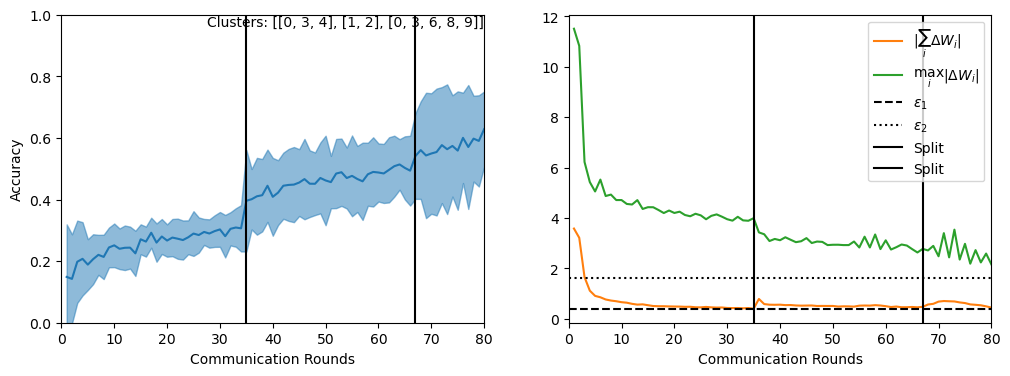

In [14]:
COMMUNICATION_ROUNDS = 80
EPS_1 = 0.4
EPS_2 = 1.6
    
cfl_stats = ExperimentLogger()
    
cluster_indices = [np.arange(len(clients)).astype("int")]
client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

for c_round in range(1, COMMUNICATION_ROUNDS+1):

    if c_round == 1:
        for client in clients:
            client.synchronize_with_server(server)
            
    participating_clients = server.select_clients(clients, frac=1.0)

    for client in participating_clients:
        train_stats = client.compute_weight_update(epochs=1)
        client.reset()

    similarities = server.compute_pairwise_similarities(clients)

    cluster_indices_new = []
    for idc in cluster_indices:
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
             
        if mean_norm<EPS_1 and max_norm>EPS_2 and len(idc)>2 and c_round>20:
            
            server.cache_model(idc, clients[idc[0]].W, acc_clients)
            
            c1, c2 = server.cluster_clients(similarities[idc][:,idc]) 
            cluster_indices_new += [c1, c2]
             
            cfl_stats.log({"split" : c_round})

        else:
            cluster_indices_new += [idc]
        
        
    cluster_indices = cluster_indices_new
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

    server.aggregate_clusterwise(client_clusters)

    acc_clients = [client.evaluate() for client in clients]
    
    cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                  "rounds" : c_round, "clusters" : cluster_indices})
    
    
    display_train_stats(cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS)

In [15]:
results = np.zeros([10, len(server.model_cache)])
for i, (idcs, W, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

Result:

In [16]:
frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) 
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9
FL Model,0.265672,0.411429,0.320843,0.183432,0.215548,0.276836,0.430147,0.280347,0.317176,0.363475
Model 0,0.000000,0.641143,0.578454,0.000000,0.293286,0.418079,0.000000,0.563584,0.000000,0.000000
